# Step Test: Model

### Read the Data File

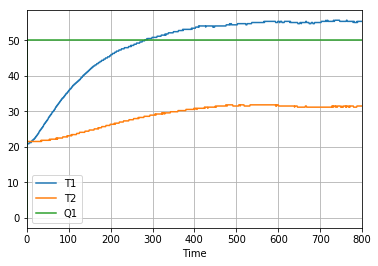

In [4]:
%matplotlib inline
import pandas as pd

pd.read_csv('Step_Test_Data.csv').set_index('Time').plot(grid=True)

## Parameter Estimation

## Fitting the Step Change Data to a First Order Model

For a first-order linear system initially at steady-state, the response to a step input change at $t=0$ is given by

$$y(t) = y(0) + K(1 - e^{-t/\tau}) \Delta U$$

where $\Delta U$ is the magnitude of the step change. Converting to notation used for the temperature control lab where $y(t) = T_1(t)$ and $\Delta U = \Delta Q_1$

$$T_1(t) = T_1(0) + K_1(1 - e^{-t/\tau_1}) \Delta Q_1$$

the following cells provide initial estimates for the steady state gain $K_1$ and time constant $\tau_1$.

### Reading Saved Data

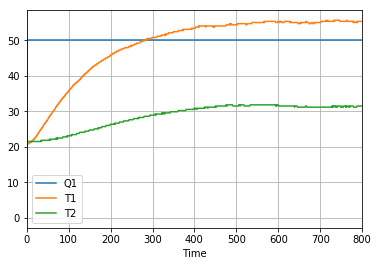

In [5]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('Step_Test_Data.csv')
df = df.set_index('Time')
df[['Q1','T1','T2']].plot(grid=True)

### Estimating Gain and Time Constant

In the limit $t\rightarrow\infty$ the first order model becomes

$$T_1(\infty) = T_1(0) + K_1\Delta Q_1$$

which provides an method for estimating $K_1$

$$K_1 = \frac{T_1(\infty) - T_1(0)}{\Delta Q_1}$$

These calculations are performed below where we use the first and last measurements of $T_1$ as estimates of $T_1(0)$ and $T_1(\infty)$, respectively.

In [6]:
T1 = df['T1']
Q1 = df['Q1']

DeltaT1 = max(T1) - min(T1)
DeltaQ1 = Q1.mean()

K1 = DeltaT1/DeltaQ1
print("K1 is approximately", K1)

K1 is approximately 0.69687


In [7]:
# find when the increase in T1 gets larger than 63.2% of the final increase
i = (T1 - T1.min()) > 0.632*(T1.max()-T1.min())
tau1 = T1.index[i].min()
print("tau1 is approximately", tau1, "seconds")

tau1 is approximately 163.0 seconds


Text(0.5,1,'Residual Error')

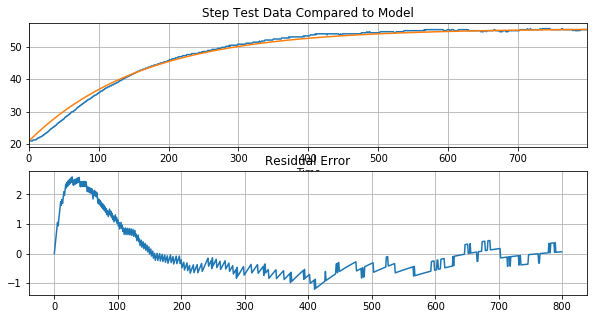

In [8]:
import matplotlib.pyplot as plt
import numpy as np

exp = np.exp
t = df.index

T1_est = T1.min() + K1*(1 - exp(-t/tau1))*DeltaQ1

plt.figure(figsize=(10,5))
ax = plt.subplot(2,1,1)
df['T1'].plot(ax = ax, grid=True)
plt.plot(t,T1_est)
plt.title('Step Test Data Compared to Model')

plt.subplot(2,1,2)
plt.plot(t,T1_est-T1)
plt.grid()
plt.title('Residual Error')

A first order model captures certain features, and provides a reasonably good result as the system approaches a new steady-state. The problem, however, is that for control we need a good model during initial transient. This is where the first-order model breaks down and predicts a qualitatively different response from what we observe.

## First Order plus Dead Time

$$T_1(t) = T_1(0) + K (1-e^\frac{t-\theta}{\tau}) Q_{step}$$

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact

df = pd.read_csv('step_test_data.csv')
df = df.set_index('Time')

T1 = df['T1']
Q1 = df['Q1']
t = df.index

DeltaT1 = max(T1) - min(T1)
DeltaQ1 = Q1.mean()

K1 = DeltaT1/DeltaQ1
i = (T1 - T1.min()) > 0.632*(T1.max()-T1.min())
tau1 = T1.index[i].min()

def fopdt(K=K1, tau=tau1, theta=0, T10=T1.min()):
    def Q1(t):
        return 0 if t < 0 else DeltaQ1
    Q1vec = np.vectorize(Q1)
    T1_fopdt = T10 + K*(1-np.exp(-(t-theta)/tau))*Q1vec(t-theta)
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(t,T1_fopdt)
    plt.plot(t,df['T1'])
    plt.subplot(2,1,2)
    plt.plot(t,T1_fopdt - T1)
    plt.show()
    
interact(fopdt,K=(0,1,.001),tau=(50,200,.5),theta=(0,50,.5),T10=(15,25,.1))

A Jupyter Widget

<function __main__.fopdt>

## Second Order

SEMD Eqn. 5-48

$$T_1(t) = T_1(0) + K\left(1 - \frac{\tau_1 e^{-t/\tau_1} - \tau_2 e^{-t/\tau_2}}{\tau_1 - \tau_2}\right)Q_1(t)$$

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact

df = pd.read_csv('step_test_data.csv')
df = df.set_index('Time')

T1 = df['T1']
Q1 = df['Q1']
t = df.index

DeltaT1 = max(T1) - min(T1)
DeltaQ1 = Q1.mean()

K1 = DeltaT1/DeltaQ1
i = (T1 - T1.min()) > 0.632*(T1.max()-T1.min())
tau1 = T1.index[i].min()

def secondorder(K=K1, tau1=tau1, tau2=40, T10=T1.min()):
    def Qscalar(t):
        return 0 if t < 0 else DeltaQ1
    Q = np.vectorize(Qscalar)
    exp = np.exp
    T = T10 + K*(1 - (tau1*exp(-t/tau1) - tau2*exp(-t/tau2))/(tau1-tau2))*Q(t)
    plt.subplot(2,1,1)
    plt.plot(t,T)
    plt.plot(t,df['T1'])
    plt.subplot(2,1,2)
    plt.plot(t,T1 - T)
    plt.show()
    
interact(secondorder,K=(0,1,.001),tau1=(1,200,.1),tau2=(0,200,.1),T10=(15,25,.1))

A Jupyter Widget

<function __main__.secondorder>

## Fitting a Second Order Model by Least Squares

In [12]:
from scipy.optimize import least_squares
import numpy as np
Qmax = 50

def f(x):
    K,tau1,tau2,T10 = x
    t = df.index
    exp = np.exp
    Tpred = T10 + K*(1 - (tau1*exp(-t/tau1) - tau2*exp(-t/tau2))/(tau1-tau2))*Qmax
    resid = df['T1'] - Tpred
    return resid

ic = [0.86,40,130,20]

r = least_squares(f,ic,bounds=(0,np.inf))
r.x

array([   0.69537389,   19.68872634,  141.40950934,   20.91093837])

$$ G_1(s) = \frac{0.70}{(20s + 1)(141s + 1)} $$